# Using faithfulness metrics to evaluate a model

In [1]:
import torch 
from torch.nn import Module,Sequential,Softmax
import torchvision 
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt 
from captum.attr import LayerGradCam,LayerAttribution

from saliency_maps_metrics.single_step_metrics import IIC_AD, ADD 
from saliency_maps_metrics.multi_step_metrics import Deletion, Insertion


/home/E144069X/miniconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting up image classification dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


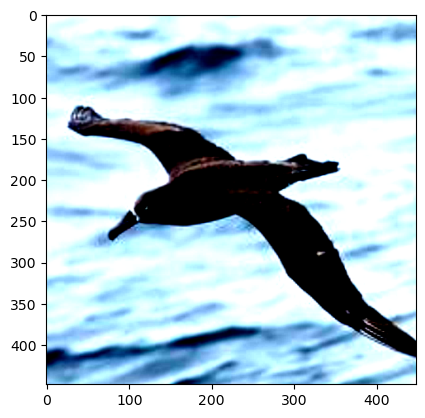

In [2]:
val_batch_size = 10

cropped_img_size = 448
img_size=int(cropped_img_size / 0.875)

transf = [transforms.Resize(img_size),transforms.CenterCrop(cropped_img_size)]
transf.extend([transforms.ToTensor()])
transf.extend([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transf = transforms.Compose(transf)

test_dataset = ImageFolder("./data/CUB_200_2011_test/",transform=transf)
testLoader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=val_batch_size,num_workers=4,pin_memory=True,shuffle=True)

batch = test_dataset.__getitem__(0)
plt.figure()
plt.imshow(batch[0].permute(1,2,0).numpy())
plt.show()

## Building model and loading pretrained weights

In [3]:
model = torchvision.models.resnet50(num_classes=200)
model.load_state_dict(torch.load("model_cub.pth",map_location="cpu"))
model = model.eval()
model = Sequential(model,Softmax(dim=-1))

## Testing Grad-CAM on one image

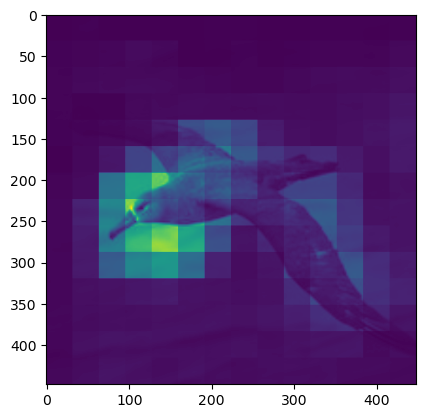

In [4]:
gradcam = LayerGradCam(model,getattr(model,"0").layer4)

batch = test_dataset.__getitem__(0)[0].unsqueeze(0)
class_ind = model(batch).argmax(dim=-1)
attr = gradcam.attribute(batch,class_ind)
upsampled_attr = LayerAttribution.interpolate(attr, (448, 448))

upsampled_attr = (upsampled_attr - upsampled_attr.min())/(upsampled_attr.max()-upsampled_attr.min())
batch = (batch - batch.min())/(batch.max()-batch.min())

img_to_viz = (upsampled_attr*batch.mean(dim=1,keepdim=True)).detach()
img_to_viz = img_to_viz[0].permute(1,2,0)

plt.figure()
plt.imshow(img_to_viz)
plt.show()

## Computing Grad-CAM maps on several test images

In [5]:
torch.manual_seed(0)
inds = torch.randint(size=(1,),high=len(test_dataset))

allImg = []
allExpl = []
allInds = []

for ind in inds:
    
    batch = test_dataset.__getitem__(ind)
    img = batch[0].unsqueeze(0)
    class_ind = model(img).argmax(dim=-1)
    attr = gradcam.attribute(img,class_ind)
    
    allImg.append(img)
    allExpl.append(attr)
    allInds.append(class_ind)

allImg = torch.cat(allImg,dim=0)
allExpl = torch.cat(allExpl,dim=0)
allInds = torch.cat(allInds,dim=0)

## Computing single-step metrics

In [6]:
iic_ad = IIC_AD()
result_dic = iic_ad(model,allImg,allExpl,allInds)  
iic_mean,ad_mean = result_dic["iic"],result_dic["ad"]
print("IIC",iic_mean)
print("AD",ad_mean)

add = ADD()
result_dic = add(model,allImg,allExpl,allInds) 
add_mean = result_dic["add"]
print("ADD",add_mean)
    

IIC tensor(0.)
AD tensor(0.1349)
ADD tensor(0.8974)


## Computing multi-step metrics

In [ ]:
allExpl = torch.nn.functional.interpolate(allExpl,(3,3))

deletion = Deletion(allImg.shape,allExpl.shape)
result_dic = deletion(model,allImg.clone(),allExpl.clone(),allInds)
dauc_mean = result_dic["dauc"]
dc_mean = result_dic["dc"]
print("DAUC",dauc_mean)
print("DC",dc_mean)

insertion = Insertion(allImg.shape,allExpl.shape)
result_dic = insertion(model,allImg.clone(),allExpl.clone(),allInds)
iauc_mean = result_dic["iauc"]
ic_mean = result_dic["ic"]
print("IAUC",iauc_mean) 
print("IC",ic_mean)